In [1]:
setwd('/import/DB/fel/BJTC-204')

In [2]:
load('/import/mdd.rna/GSE101521.rda')

In [3]:
count = expr3

In [4]:
dim(expr3)

[1] 33714    60

In [5]:
rownames(count) = count[,1]

In [6]:
count = count[,-1]

In [11]:
library(dplyr)

In [12]:
cli = cli %>%  dplyr::filter(V2 != 'MDD')

In [13]:
table(cli$V2)


  CON MDD-S 
   29    21 

In [14]:
rownames(cli) = cli[,1]

In [15]:
con.sample = cli %>%  dplyr::filter(V2 =='CON') %>% rownames()

In [16]:
MDD.sample = cli %>%  dplyr::filter(V2 =='MDD-S') %>% rownames()

In [17]:
control = count[,con.sample]
MDD = count[,MDD.sample]

In [18]:
exp <- cbind(control, MDD)

In [19]:
group=c(rep("control",dim(control)[2]),rep("MDD_S",dim(MDD)[2])) 

In [20]:
library("edgeR")  
library(dplyr)
library(ggrepel)
library(ggplot2)
library(cowplot)

dimnames=list(rownames(exp),colnames(exp))
data=matrix(as.numeric(as.matrix(exp)),nrow=nrow(exp),dimnames=dimnames)
data=avereps(data)
data=data[rowMeans(data)>1,]
design <- model.matrix(~group)
y <- DGEList(counts=data,group=group)
y <- calcNormFactors(y)
y <- estimateCommonDisp(y)
y <- estimateTagwiseDisp(y)
et <- exactTest(y,pair = c("control","MDD_S"))
topTags(et)

Warning message:
"package 'edgeR' was built under R version 4.2.3"
Loading required package: limma

Warning message:
"package 'limma' was built under R version 4.2.3"
Warning message:
"package 'ggrepel' was built under R version 4.2.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'cowplot' was built under R version 4.2.3"


,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
HSPA6,-6.104193,5.353215,1.979610e-11,4.532911e-07
HSPA7,-4.572972,3.536277,6.395158e-09,7.321817e-05
SERPINH1,-2.988767,3.871691,2.133739e-08,1.628612e-04
FOS,-1.900876,6.058539,1.048421e-07,6.001686e-04
ATF3,-1.994609,3.268687,1.889130e-07,7.323496e-04
CXCL8,-3.719000,2.868411,1.918987e-07,7.323496e-04
CCL2,-2.584140,1.758765,2.456681e-07,7.620240e-04
HSPA1A,-1.907781,8.850693,2.662325e-07,7.620240e-04
HSPA1B,-1.844953,8.875640,3.105550e-07,7.901210e-04


In [77]:
group

[1] "control" "control" "control" "control" "control" "control" "control"
 [8] "control" "control" "control" "control" "control" "control" "control"
[15] "control" "control" "control" "control" "control" "control" "control"
[22] "control" "control" "control" "control" "control" "control" "control"
[29] "control" "MDD_S"   "MDD_S"   "MDD_S"   "MDD_S"   "MDD_S"   "MDD_S"  
[36] "MDD_S"   "MDD_S"   "MDD_S"   "MDD_S"   "MDD_S"   "MDD_S"   "MDD_S"  
[43] "MDD_S"   "MDD_S"   "MDD_S"   "MDD_S"   "MDD_S"   "MDD_S"   "MDD_S"  
[50] "MDD_S"

In [157]:
foldChange=0.5
padj=0.05

ordered_tags <- topTags(et, n=100000)
allDiff=ordered_tags$table
allDiff=allDiff[is.na(allDiff$FDR)==FALSE,]
diff=allDiff
diff$group = as.factor(ifelse(diff$PValue < padj & abs(diff$logFC) >= foldChange, 
                             ifelse(diff$logFC> foldChange ,'Up','Down'),'NoSignifi'))
table(diff$group)


     Down NoSignifi        Up 
      413     22228       257 

In [187]:
diff['SFXN3',]

,logFC,logCPM,PValue,FDR,group
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
SFXN3,0.03556112,5.871881,0.6694895,1,NoSignifi


### limma

In [158]:
group_list = group

In [159]:
group_list = factor(group_list,levels = c("control","MDD_S"))

In [160]:
library(limma)

design <- model.matrix(~0+group_list)
colnames(design)=levels(group_list)
rownames(design)=colnames(exp)

dge <- DGEList(counts=exp)
dge <- calcNormFactors(dge)

v <- voom(dge,design, normalize="quantile")
fit <- lmFit(v, design)

In [161]:


constrasts = paste(rev(levels(group_list)),collapse = "-")
cont.matrix <- makeContrasts(contrasts=constrasts,levels = design) 
fit2=contrasts.fit(fit,cont.matrix)
fit2=eBayes(fit2)

DEG = topTable(fit2, coef=constrasts, n=Inf)
DEG = na.omit(DEG)

In [162]:
tail(DEG,2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DYNC1H1,-0.0091164245,11.00912,-0.093625017,0.9257914,1,-6.400900
RNU1-3,0.0006883111,11.26356,0.008887018,0.9929456,1,-6.412858


In [164]:
foldChange=0.5
padj=0.05

diff2=DEG
diff2$group = as.factor(ifelse(diff2$P.Value < padj & abs(diff2$logFC) >= foldChange, 
                             ifelse(diff2$logFC> foldChange ,'Up','Down'),'NoSignifi'))
table(diff2$group)


     Down NoSignifi        Up 
      336     33122       256 

In [165]:
edger_up = diff %>%  filter(group == 'Up') %>% rownames()
limma_up = diff2 %>%  filter(group == 'Up')%>% rownames()

In [166]:
allup = intersect(edger_up,limma_up)

In [167]:
edger_down = diff %>%  filter(group == 'Down') %>% rownames()
limma_down = diff2 %>%  filter(group == 'Down')%>% rownames()

In [168]:
alldown = intersect(edger_down,limma_down)

In [169]:
allup

[1] "LINC01088"    "CSP2"         "RPL31P61"     "LOC284344"    "MRNIP-DT"    
  [6] "MOGAT1"       "LINC01010"    "LMNTD1"       "PTGDR"        "LOC100652967"
 [11] "TRPM1"        "SLC25A21-AS1" "RNA5SP122"    "BNIP3P42"     "RNU6-539P"   
 [16] "MTCO1P30"     "RPL23AP52"    "RPL21P125"    "PARK7P1"      "LINC00397"   
 [21] "TINAG"        "MIR586"       "NDUFB5P2"     "DNAH12"       "ADIRF"       
 [26] "IFNW1"        "CYP4B1"       "MIR4296"      "RPL7P60"      "RPL34P11"    
 [31] "LINC02080"    "RN7SL418P"    "RPL8P5"       "OR7E128P"     "RN7SL116P"   
 [36] "DUXAP1"       "GTF2IP14"     "CYP2G1P"      "C10orf62"     "ZKSCAN8P2"   
 [41] "MCCD1P1"      "AWAT1"        "NFIA-AS2"     "HNRNPA1P33"   "ADAMTS14"    
 [46] "ABCF2P2"      "RNU7-95P"     "ST3GAL3-AS1"  "GRID1-AS1"    "RNU6-1043P"  
 [51] "RNU6-1048P"   "UNC5CL"       "RPS7P10"      "LOC124903416" "MIR4666A"    
 [56] "RNU6-883P"    "SNORD89"      "RNU6-435P"    "RNU6-581P"    "RNU6-957P"   
 [61] "LOC124900265" "PLA2G4B"      "RN7SL608P"    "RPL13AP11"    "LINC02430"   
 [66] "MIR4524B"     "RPL34P13"     "MTND6P5"      "RN7SL656P"    "RPL26P27"    
 [71] "RN7SL199P"    "LOC100421622" "FAM236D"      "LINC02112"    "MIR374A"     
 [76] "SGO1"         "LOC101928988" "KIF25-AS1"    "MIR1913"      "LINC02395"   
 [81] "KRT12"        "IL21R-AS1"    "RPS7P3"       "RNA5S9"       "RNU6-951P"   
 [86] "MAP1LC3B2"    "RN7SKP239"    "AP1M2P1"      "LINC02346"    "RNU2-7P"     
 [91] "UNC5B-AS1"    "LOC101927908" "LOC124904152" "RN7SL521P"    "WDR72"       
 [96] "MIR4659A"     "LINC00106"    "TRIM26BP"     "MIR3186"      "HPN-AS1"     
[101] "RNU6-1079P"   "MIR26A1"      "VN1R40P"      "MTCO2P11"     "RPSAP51"

In [233]:
alldown

[1] "HSPA6"        "FOS"          "ATF3"         "CXCL8"        "CCL2"        
  [6] "HSPA1A"       "HSPA1B"       "DNAJB1"       "FOSB"         "TNFAIP3"     
 [11] "CH25H"        "NR4A1"        "IL1B"         "RRAD"         "CDKN1A"      
 [16] "ZFP36"        "RGS16"        "ADM"          "PNP"          "RN7SL472P"   
 [21] "HS3ST3B1"     "PPP1R15A"     "ANKRD40CL"    "C4orf54"      "PLAUR"       
 [26] "JUN"          "PTGS2"        "LOC105371795" "LOC105374085" "TNFRSF12A"   
 [31] "EGR2"         "LINC02268"    "TFPI2"        "EPHA1"        "COL4A1"      
 [36] "TM4SF1"       "IL6"          "IL1A"         "C5AR1"        "SLC13A5"     
 [41] "GBP2"         "IL6R-AS1"     "RELB"         "SLC10A5P1"    "BTG2"        
 [46] "OXTR"         "CCRL2"        "CD28"         "SOCS3"        "MTFR2"       
 [51] "TXNDC2"       "TMPRSS3"      "EGR1"         "CXCL14"       "CALCB"       
 [56] "SRGN"         "AREG"         "TNFSF9"       "PRF1"         "RPE65"       
 [61] "CCNJL"        "KLF4"         "C1QTNF1"      "PLCZ1"        "CLEC2B"      
 [66] "TKTL2"        "RGMB-AS1"     "IER3"         "RAB38"        "KRT8P41"     
 [71] "WDR38"        "MICB"         "IGHG1"        "LINC00671"    "DIO2"        
 [76] "PARM1-AS1"    "DUSP2"        "RPL23AP57"    "PPP1R12BP1"   "ESM1"        
 [81] "PLA2G5"       "ST8SIA2"      "GRK7"         "ECSCR"        "LINC03040"   
 [86] "RPS4XP1"      "EHD4-AS1"     "C2orf78"      "DUSP5"        "RNU6-1257P"  
 [91] "LINC00396"    "KCNJ16"       "TUBB8P2"      "RN7SL582P"    "CAPN11"      
 [96] "GPRC5A"       "PLA2G3"       "HAPLN3"       "TENT5C"       "ADAMTS15"    
[101] "C2CD4A"       "RAB20"        "LINC01679"    "BNIP5"        "DELEC1"      
[106] "ABCB10P3"     "LINC00943"    "CCDC102A"     "CHRND"        "KRT8P5"      
[111] "MUC17"        "SNORD113-7"   "KLHL6"        "FDPSP3"       "DLEC1P1"     
[116] "HCST"         "RDH10-AS1"    "PRLHR"        "BNIP3P32"     "RNASE2"      
[121] "LINC02310"    "FRMD6-AS2"    "FRMD6-AS1"    "KRT8P3"       "RPL7AP64"    
[126] "TPSG1"        "TENT5A"       "C1orf127"     "IGSF3P2"      "CHL1-AS2"    
[131] "LOC100128164" "WEE2P1"       "LCK"          "P2RY8"        "HSPE1P28"    
[136] "OR6M3P"       "TBXA2R"       "LOC124900279" "GPS2P2"       "LINC02723"   
[141] "AHCYP2"       "TWIST1"       "KRT16P6"      "LOC101929408" "MIR4288"     
[146] "FBLN2"        "KCTD11"       "CD300E"       "SLC34A2"      "DNAH8"       
[151] "LINC02554"    "TRAPPC5"      "TUBB8B"       "GOLGA6L25"    "LINC02488"   
[156] "AGR2"         "C1orf141"     "RPL17P14"     "LOC101929124" "ECEL1"       
[161] "FTLP8"        "MIR331"       "DRD3"         "RPS10P6"      "MYO16-AS1"   
[166] "CRH"          "PRRX2"        "MIR3688-1"    "SERPINB2"     "SNORD53"     
[171] "MYL12-AS1"    "LAMP5-AS1"    "CD164L2"      "ARHGEF19"     "KLRF1"       
[176] "RPL7AP29"     "TOR4A"        "POU5F1"       "LINC01904"    "LRRC31"      
[181] "RPL14P4"      "SNHG25"       "RN7SL430P"    "SNORA80A"     "DUSP13"      
[186] "LOC124900394" "DSG3"         "LINC01471"    "RNU6-1045P"   "CD163"       
[191] "MIR378D2HG"   "C10orf95"

In [227]:
all = c(allup,alldown)

In [228]:
cg1 = all[!grepl('LINC|LOC|MIR',all)]

In [229]:
load('prot.rda')

In [230]:
cg2 = intersect(cg1,prot)

In [231]:
cg2

[1] "MOGAT1"       "PTGDR"        "TRPM1"        "SLC25A21-AS1" "TINAG"       
  [6] "DNAH12"       "ADIRF"        "IFNW1"        "CYP4B1"       "C10orf62"    
 [11] "AWAT1"        "ADAMTS14"     "UNC5CL"       "PLA2G4B"      "KRT12"       
 [16] "MAP1LC3B2"    "WDR72"        "HSPA6"        "FOS"          "ATF3"        
 [21] "CCL2"         "HSPA1A"       "HSPA1B"       "DNAJB1"       "FOSB"        
 [26] "TNFAIP3"      "CH25H"        "NR4A1"        "IL1B"         "RRAD"        
 [31] "CDKN1A"       "ZFP36"        "RGS16"        "ADM"          "PNP"         
 [36] "HS3ST3B1"     "PPP1R15A"     "PLAUR"        "JUN"          "PTGS2"       
 [41] "TNFRSF12A"    "EGR2"         "TFPI2"        "EPHA1"        "COL4A1"      
 [46] "TM4SF1"       "IL6"          "IL1A"         "C5AR1"        "SLC13A5"     
 [51] "GBP2"         "RELB"         "BTG2"         "OXTR"         "CCRL2"       
 [56] "CD28"         "SOCS3"        "MTFR2"        "TXNDC2"       "TMPRSS3"     
 [61] "EGR1"         "CXCL14"       "CALCB"        "SRGN"         "AREG"        
 [66] "TNFSF9"       "PRF1"         "RPE65"        "CCNJL"        "KLF4"        
 [71] "C1QTNF1"      "PLCZ1"        "CLEC2B"       "TKTL2"        "IER3"        
 [76] "RAB38"        "WDR38"        "MICB"         "DIO2"         "DUSP2"       
 [81] "ESM1"         "PLA2G5"       "ST8SIA2"      "GRK7"         "ECSCR"       
 [86] "C2orf78"      "DUSP5"        "KCNJ16"       "CAPN11"       "GPRC5A"      
 [91] "PLA2G3"       "HAPLN3"       "ADAMTS15"     "C2CD4A"       "RAB20"       
 [96] "CCDC102A"     "CHRND"        "MUC17"        "KLHL6"        "HCST"        
[101] "PRLHR"        "RNASE2"       "TPSG1"        "C1orf127"     "LCK"         
[106] "P2RY8"        "TBXA2R"       "TWIST1"       "FBLN2"        "KCTD11"      
[111] "CD300E"       "SLC34A2"      "DNAH8"        "TRAPPC5"      "AGR2"        
[116] "C1orf141"     "ECEL1"        "DRD3"         "CRH"          "PRRX2"       
[121] "SERPINB2"     "CD164L2"      "ARHGEF19"     "KLRF1"        "TOR4A"       
[126] "POU5F1"       "LRRC31"       "DUSP13"       "DSG3"         "CD163"       
[131] "C10orf95"

In [234]:
gene38 = read.table('./gene386.txt',header =T)

In [235]:
intersect(cg2,gene38$Gene)

[1] "ADM"   "TOR4A"

In [232]:
exp1 = exp[cg2,] %>%  t() 
save(exp1,group,file = 'bulk2.rda')

In [182]:
save(exp,group,file = 'exp.rda')

### 加上芯片数据   不运行


In [219]:
load('array.rda')

In [220]:
length(arrayup)

[1] 2477

In [221]:
allup

[1] "LINC01088"    "CSP2"         "RPL31P61"     "LOC284344"    "MRNIP-DT"    
  [6] "MOGAT1"       "LINC01010"    "LMNTD1"       "PTGDR"        "LOC100652967"
 [11] "TRPM1"        "SLC25A21-AS1" "RNA5SP122"    "BNIP3P42"     "RNU6-539P"   
 [16] "MTCO1P30"     "RPL23AP52"    "RPL21P125"    "PARK7P1"      "LINC00397"   
 [21] "TINAG"        "MIR586"       "NDUFB5P2"     "DNAH12"       "ADIRF"       
 [26] "IFNW1"        "CYP4B1"       "MIR4296"      "RPL7P60"      "RPL34P11"    
 [31] "LINC02080"    "RN7SL418P"    "RPL8P5"       "OR7E128P"     "RN7SL116P"   
 [36] "DUXAP1"       "GTF2IP14"     "CYP2G1P"      "C10orf62"     "ZKSCAN8P2"   
 [41] "MCCD1P1"      "AWAT1"        "NFIA-AS2"     "HNRNPA1P33"   "ADAMTS14"    
 [46] "ABCF2P2"      "RNU7-95P"     "ST3GAL3-AS1"  "GRID1-AS1"    "RNU6-1043P"  
 [51] "RNU6-1048P"   "UNC5CL"       "RPS7P10"      "LOC124903416" "MIR4666A"    
 [56] "RNU6-883P"    "SNORD89"      "RNU6-435P"    "RNU6-581P"    "RNU6-957P"   
 [61] "LOC124900265" "PLA2G4B"      "RN7SL608P"    "RPL13AP11"    "LINC02430"   
 [66] "MIR4524B"     "RPL34P13"     "MTND6P5"      "RN7SL656P"    "RPL26P27"    
 [71] "RN7SL199P"    "LOC100421622" "FAM236D"      "LINC02112"    "MIR374A"     
 [76] "SGO1"         "LOC101928988" "KIF25-AS1"    "MIR1913"      "LINC02395"   
 [81] "KRT12"        "IL21R-AS1"    "RPS7P3"       "RNA5S9"       "RNU6-951P"   
 [86] "MAP1LC3B2"    "RN7SKP239"    "AP1M2P1"      "LINC02346"    "RNU2-7P"     
 [91] "UNC5B-AS1"    "LOC101927908" "LOC124904152" "RN7SL521P"    "WDR72"       
 [96] "MIR4659A"     "LINC00106"    "TRIM26BP"     "MIR3186"      "HPN-AS1"     
[101] "RNU6-1079P"   "MIR26A1"      "VN1R40P"      "MTCO2P11"     "RPSAP51"

In [222]:
intersect(arraydown,alldown)

[1] "PLAUR"     "BTG2"      "IL1A"      "RNASE2"    "C1QTNF1"   "LCK"      
 [7] "PLA2G5"    "TMPRSS3"   "GPRC5A"    "ECEL1"     "KLF4"      "DIO2"     
[13] "OXTR"      "EPHA1"     "TNFAIP3"   "HS3ST3B1"  "PRRX2"     "CALCB"    
[19] "CD28"      "RAB20"     "RAB38"     "KLRF1"     "AGR2"      "CCNJL"    
[25] "PRF1"      "DSG3"      "CD163"     "SERPINB2"  "SLC34A2"   "ST8SIA2"  
[31] "CLEC2B"    "TFPI2"     "DRD3"      "RGS16"     "TPSG1"     "TNFRSF12A"
[37] "RELB"      "KCNJ16"    "DUSP13"    "TM4SF1"    "CCL2"      "IL6"      
[43] "CHRND"     "ZFP36"     "COL4A1"

In [223]:
ee = intersect(arraydown,alldown)

In [224]:
ee2 = intersect(cg2,ee)

In [225]:
exp1 = exp[ee2,] %>%  t() 
save(exp1,group,file = 'bulk2.rda')

In [226]:
save(ee2,file = 'ee2.rda')

Standard deviations (1, .., p=50):
 [1] 1.153782e+01 7.763194e+00 6.425000e+00 5.741187e+00 5.035658e+00
 [6] 4.512085e+00 4.165425e+00 3.870292e+00 3.665619e+00 3.589828e+00
[11] 3.482995e+00 3.394130e+00 3.295198e+00 3.218188e+00 3.071933e+00
[16] 3.017375e+00 2.933028e+00 2.889236e+00 2.823438e+00 2.725700e+00
[21] 2.699396e+00 2.684683e+00 2.589451e+00 2.539486e+00 2.470811e+00
[26] 2.438741e+00 2.390360e+00 2.351214e+00 2.307274e+00 2.288386e+00
[31] 2.214257e+00 2.175410e+00 2.154720e+00 2.112093e+00 2.092286e+00
[36] 2.039513e+00 2.009766e+00 1.970304e+00 1.916240e+00 1.872147e+00
[41] 1.824329e+00 1.822134e+00 1.789119e+00 1.752074e+00 1.712228e+00
[46] 1.673080e+00 1.639444e+00 1.590350e+00 1.579649e+00 8.627448e-15

Rotation (n x k) = (598 x 50):
                          PC1           PC2           PC3           PC4
CXCL14          -0.0614976618  3.804596e-02  1.439730e-02 -0.0810123154
DOK5            -0.0513873916  9.200584e-02  3.612450e-02  0.0161016206
SLC13A5         -

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V1,-16.428078,6.832364,6.384236,0.3102002,4.5772097,-1.9438633,5.825781,-2.3419461,1.2529849,-1.308851,...,0.1846851,0.1229285,0.1565353,-0.6745567,-0.02957986,-0.27113904,0.82695435,0.4230266,-0.3248047,-9.769963e-15
V2,-5.384120,2.386560,-1.886566,-1.4483560,6.3478148,-0.4551656,3.461836,-2.7756191,3.2595875,2.548844,...,0.4073136,-0.5750582,0.9360854,-1.1649612,-0.70523458,-0.29026981,-0.17109002,1.6747600,-0.1418870,-9.492407e-15
V3,-8.298539,5.662397,6.279571,-2.0836429,-0.6464844,6.0662745,1.047560,-2.3847935,-4.9436169,4.419609,...,0.1498450,0.4237783,-1.6975260,0.2593078,-0.40340495,0.06653633,1.04260642,-0.1610421,-0.8666312,-9.658940e-15
V4,-14.947429,2.321164,4.956997,-0.4824117,0.3756272,1.0844059,6.096069,-1.1711353,0.7964328,-1.106076,...,0.2177790,2.4546161,0.5610101,4.3835494,1.21980952,-3.00226621,0.99841184,2.5767945,4.9223943,-6.050715e-15
V5,-10.749156,2.660164,5.985804,-1.7423747,1.8182565,2.2581697,3.942976,0.8098775,-1.9413955,1.755320,...,0.7811526,-0.4038697,0.6199790,-1.5286284,-0.91690213,1.65510911,-0.62298478,-0.5948607,-0.6676462,-8.548717e-15
V6,-26.220474,-8.473466,-14.419184,14.0408364,0.6530791,4.0649271,-4.799764,-2.7612576,-9.6574900,10.968295,...,-0.6269116,0.5644686,-0.2146759,0.4084667,0.09372677,0.25058043,-0.07940827,0.3236515,-0.1017201,-7.771561e-15


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
V1,-16.428078,6.832364,6.384236,0.3102002,4.5772097,-1.9438633,5.825781,-2.3419461,1.2529849,-1.308851,...,0.1229285,0.1565353,-0.6745567,-0.02957986,-0.27113904,0.82695435,0.4230266,-0.3248047,-9.769963e-15,control
V2,-5.384120,2.386560,-1.886566,-1.4483560,6.3478148,-0.4551656,3.461836,-2.7756191,3.2595875,2.548844,...,-0.5750582,0.9360854,-1.1649612,-0.70523458,-0.29026981,-0.17109002,1.6747600,-0.1418870,-9.492407e-15,control
V3,-8.298539,5.662397,6.279571,-2.0836429,-0.6464844,6.0662745,1.047560,-2.3847935,-4.9436169,4.419609,...,0.4237783,-1.6975260,0.2593078,-0.40340495,0.06653633,1.04260642,-0.1610421,-0.8666312,-9.658940e-15,control
V4,-14.947429,2.321164,4.956997,-0.4824117,0.3756272,1.0844059,6.096069,-1.1711353,0.7964328,-1.106076,...,2.4546161,0.5610101,4.3835494,1.21980952,-3.00226621,0.99841184,2.5767945,4.9223943,-6.050715e-15,control
V5,-10.749156,2.660164,5.985804,-1.7423747,1.8182565,2.2581697,3.942976,0.8098775,-1.9413955,1.755320,...,-0.4038697,0.6199790,-1.5286284,-0.91690213,1.65510911,-0.62298478,-0.5948607,-0.6676462,-8.548717e-15,control
V6,-26.220474,-8.473466,-14.419184,14.0408364,0.6530791,4.0649271,-4.799764,-2.7612576,-9.6574900,10.968295,...,0.5644686,-0.2146759,0.4084667,0.09372677,0.25058043,-0.07940827,0.3236515,-0.1017201,-7.771561e-15,control


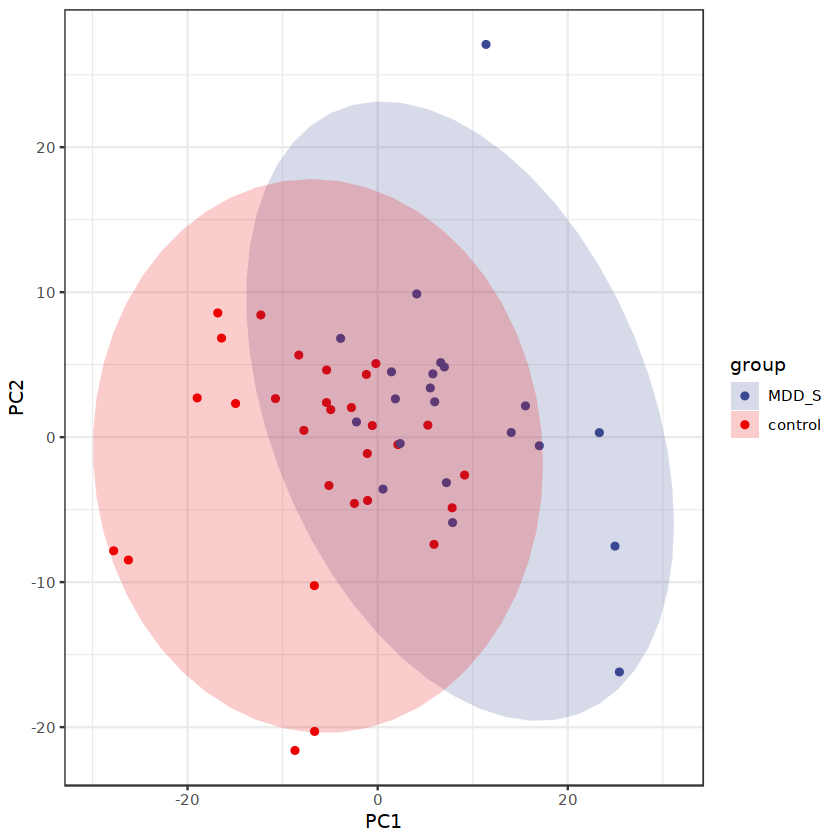

In [82]:
diff1 = diff %>%  filter(group != 'NoSignifi')

count = exp

#cg=names(tail(sort(apply(count,1,sd)),3000))

cg = diff1 %>%  rownames()

n=exp[cg,]

n = cpm(log2(n+1))

pca.res <- prcomp(t(n), scale. = T, center = T)  # 
pca.res

tmp <- as.data.frame(pca.res$x)
head(tmp)

tmp$group <- group
head(tmp)

library(ggplot2)
library(ggsci)

ggplot(tmp, aes(PC1, PC2))+
  geom_point(aes(color = group))+
  stat_ellipse(aes(fill=group), alpha = 0.2,
               geom ="polygon",type = "norm")+
  scale_fill_aaas()+
  scale_color_aaas()+
  theme_bw()

### limma

In [74]:
data  = exp 

In [75]:
library(DESeq2)
library(limma)
library(edgeR)

Warning message:
"package 'DESeq2' was built under R version 4.2.3"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.3"
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following object is masked from 'package:limma':

    plotMA


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min



Attac

ERROR: Error: package or namespace load failed for 'DESeq2':
 .onLoad failed in loadNamespace() for 'RSQLite', details:
  call: loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]])
  error: namespace 'fastmap' 1.1.1 is already loaded, but >= 1.2.0 is required


In [76]:
group_list = factor(group)
design <- model.matrix(~0+group_list)
rownames(design) = colnames(data)
colnames(design) <- levels(group_list)

keep_gene
FALSE  TRUE 
18644 15070 

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TMED9,-0.2427905,4.415787,-3.836364,0.0003405586,0.9879296,-1.389215
URB1,0.1498586,6.023023,3.639208,0.0006307650,0.9879296,-1.448106
SIPA1L2,-0.2233842,7.129460,-3.454360,0.0011080769,0.9879296,-1.793310
CXCL14,-0.6845801,5.282421,-3.460988,0.0010861901,0.9879296,-1.826454
DOK5,-0.3779356,4.127655,-3.569566,0.0007812632,0.9879296,-1.913303
SLC13A5,-0.6270272,3.411474,-3.759579,0.0004337375,0.9879296,-1.985283


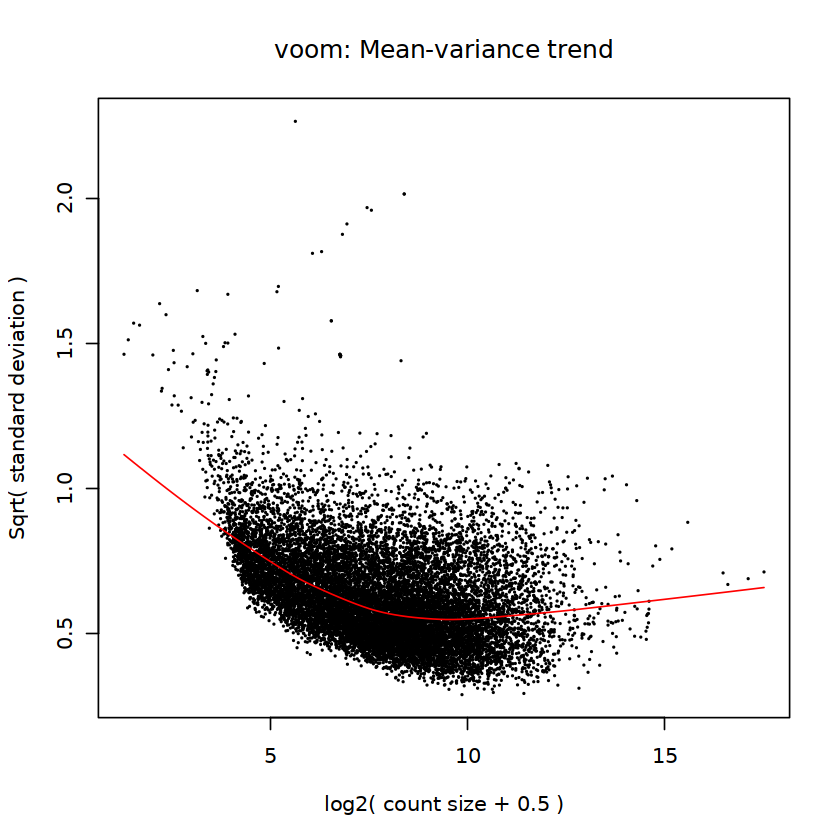

In [126]:
DGElist <- DGEList( counts = data, group = group_list )
keep_gene <- rowSums( cpm(DGElist) > 3 ) >= 5 # 自定义
table(keep_gene)
DGElist <- DGElist[ keep_gene, , keep.lib.sizes = FALSE ]

DGElist <- calcNormFactors( DGElist )
v <- voom(DGElist, design, plot = TRUE, normalize = "quantile")
fit <- lmFit(v, design)
cont.matrix <- makeContrasts(contrasts = c('MDD_S -control'), levels = design)

fit2 <- contrasts.fit(fit, cont.matrix)
fit2 <- eBayes(fit2)

nrDEG_limma_voom = topTable(fit2, coef = 'MDD_S -control', n = Inf)
nrDEG_limma_voom = na.omit(nrDEG_limma_voom)
head(nrDEG_limma_voom)


In [133]:
padj = 0.05 # 自定义
foldChange= 0.4 # 自定义
nrDEG_limma_voom_signif = nrDEG_limma_voom[(nrDEG_limma_voom$P.Value < padj & 
                          (nrDEG_limma_voom$logFC>foldChange | nrDEG_limma_voom$logFC<(-foldChange))),]
nrDEG_limma_voom_signif = nrDEG_limma_voom_signif[order(nrDEG_limma_voom_signif$logFC),]
#save(nrDEG_limma_voom_signif, file = 'nrDEG_limma_voom_signif')


In [134]:
head(nrDEG_limma_voom)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TMED9,-0.2427905,4.415787,-3.836364,0.0003405586,0.9879296,-1.389215
URB1,0.1498586,6.023023,3.639208,0.0006307650,0.9879296,-1.448106
SIPA1L2,-0.2233842,7.129460,-3.454360,0.0011080769,0.9879296,-1.793310
CXCL14,-0.6845801,5.282421,-3.460988,0.0010861901,0.9879296,-1.826454
DOK5,-0.3779356,4.127655,-3.569566,0.0007812632,0.9879296,-1.913303
SLC13A5,-0.6270272,3.411474,-3.759579,0.0004337375,0.9879296,-1.985283


In [135]:
diff = nrDEG_limma_voom

In [136]:
diff$group = as.factor(ifelse(diff$P.Value < padj & abs(diff$logFC) >= foldChange, 
                                 ifelse(diff$logFC> foldChange ,'Up','Down'),'NoSignifi'))
    table(diff$group)


     Down NoSignifi        Up 
       86     14945        39 

In [137]:
diff1 = diff %>%  filter(group != 'NoSignifi')

count = exp

#cg=names(tail(sort(apply(count,1,sd)),3000))

cg = diff1 %>%  rownames()

n=exp[cg,]

n = cpm(log2(n+1))

pca.res <- prcomp(t(n), scale. = T, center = T)  # 
pca.res

tmp <- as.data.frame(pca.res$x)
head(tmp)

tmp$group <- group
head(tmp)

library(ggplot2)
library(ggsci)

Standard deviations (1, .., p=50):
 [1] 5.188315e+00 4.153228e+00 4.099818e+00 3.081711e+00 2.383389e+00
 [6] 2.228582e+00 2.062298e+00 1.994975e+00 1.817652e+00 1.615939e+00
[11] 1.524382e+00 1.458642e+00 1.387750e+00 1.368189e+00 1.292861e+00
[16] 1.248705e+00 1.186897e+00 1.111470e+00 1.080677e+00 1.062106e+00
[21] 1.035261e+00 9.601040e-01 9.482364e-01 9.188772e-01 8.754810e-01
[26] 8.488410e-01 8.247847e-01 8.037245e-01 7.741503e-01 7.279612e-01
[31] 7.214463e-01 7.113386e-01 6.920740e-01 6.558795e-01 6.396727e-01
[36] 6.201319e-01 5.896621e-01 5.780371e-01 5.514665e-01 5.228163e-01
[41] 5.105512e-01 4.966759e-01 4.870297e-01 4.604842e-01 4.213329e-01
[46] 4.011466e-01 3.549609e-01 3.382004e-01 3.284019e-01 4.612005e-15

Rotation (n x k) = (125 x 50):
                       PC1          PC2          PC3           PC4
CXCL14       -0.0641803879  0.143983597 -0.061481303 -0.1095767381
SLC13A5      -0.0307380256  0.164330346 -0.031651620 -0.1493267794
FOS          -0.1314392342 -0.07

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V1,-5.243946,4.776596,1.7703026,1.3850297,-0.7860034,0.5628922,-1.7572763,0.6260873,-1.47718643,0.1935797,...,0.1825810,0.1877232,0.34195872,0.01570233,-0.5741888,-0.13277800,-0.02326671,-0.2504061,0.10569068,4.163336e-15
V2,-3.215762,1.401453,-0.2329317,-0.1337474,-3.0103561,2.2241716,-0.1757755,2.2497122,-1.19147243,-1.9796361,...,0.5055559,0.8270733,-0.09540999,-0.79563678,0.2089482,0.44694219,-0.37181105,-0.6497098,-0.16910492,4.496403e-15
V3,-2.995516,4.237911,1.4822045,0.6485870,-3.3767729,-2.2998253,1.1869196,0.8058329,2.70140433,-0.7933722,...,-0.4278379,-0.4510015,0.05685674,0.71984797,0.1584362,-0.16690158,-0.09982202,-0.2266425,-0.23096900,4.302114e-15
V4,-6.699404,5.179108,3.3309184,2.2615393,0.2164230,-1.9507459,-1.9199901,1.3820874,2.01566429,-0.8346019,...,-0.4819818,0.1662723,0.99449828,0.04570555,0.5763413,-0.19447936,-0.12569600,-0.4289765,0.63322171,4.385381e-15
V5,-2.637789,4.187694,1.1984931,-0.4216721,-1.1670433,-1.2313050,-0.4814445,1.1570538,2.56153655,2.4561188,...,-0.9569366,-0.3648282,-0.36451128,-0.17419519,-0.6469104,-0.06828624,0.59380471,-0.1999527,-0.24232983,4.801715e-15
V6,-14.742106,-9.082882,-0.1625956,1.9280353,-2.3592354,2.5098117,1.0241720,1.6870587,0.08810435,0.2864481,...,-0.2662222,-0.5093554,0.09155398,-0.27412217,0.1642166,0.19684726,0.03851319,0.1635340,0.06136286,3.053113e-15


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
V1,-5.243946,4.776596,1.7703026,1.3850297,-0.7860034,0.5628922,-1.7572763,0.6260873,-1.47718643,0.1935797,...,0.1877232,0.34195872,0.01570233,-0.5741888,-0.13277800,-0.02326671,-0.2504061,0.10569068,4.163336e-15,control
V2,-3.215762,1.401453,-0.2329317,-0.1337474,-3.0103561,2.2241716,-0.1757755,2.2497122,-1.19147243,-1.9796361,...,0.8270733,-0.09540999,-0.79563678,0.2089482,0.44694219,-0.37181105,-0.6497098,-0.16910492,4.496403e-15,control
V3,-2.995516,4.237911,1.4822045,0.6485870,-3.3767729,-2.2998253,1.1869196,0.8058329,2.70140433,-0.7933722,...,-0.4510015,0.05685674,0.71984797,0.1584362,-0.16690158,-0.09982202,-0.2266425,-0.23096900,4.302114e-15,control
V4,-6.699404,5.179108,3.3309184,2.2615393,0.2164230,-1.9507459,-1.9199901,1.3820874,2.01566429,-0.8346019,...,0.1662723,0.99449828,0.04570555,0.5763413,-0.19447936,-0.12569600,-0.4289765,0.63322171,4.385381e-15,control
V5,-2.637789,4.187694,1.1984931,-0.4216721,-1.1670433,-1.2313050,-0.4814445,1.1570538,2.56153655,2.4561188,...,-0.3648282,-0.36451128,-0.17419519,-0.6469104,-0.06828624,0.59380471,-0.1999527,-0.24232983,4.801715e-15,control
V6,-14.742106,-9.082882,-0.1625956,1.9280353,-2.3592354,2.5098117,1.0241720,1.6870587,0.08810435,0.2864481,...,-0.5093554,0.09155398,-0.27412217,0.1642166,0.19684726,0.03851319,0.1635340,0.06136286,3.053113e-15,control


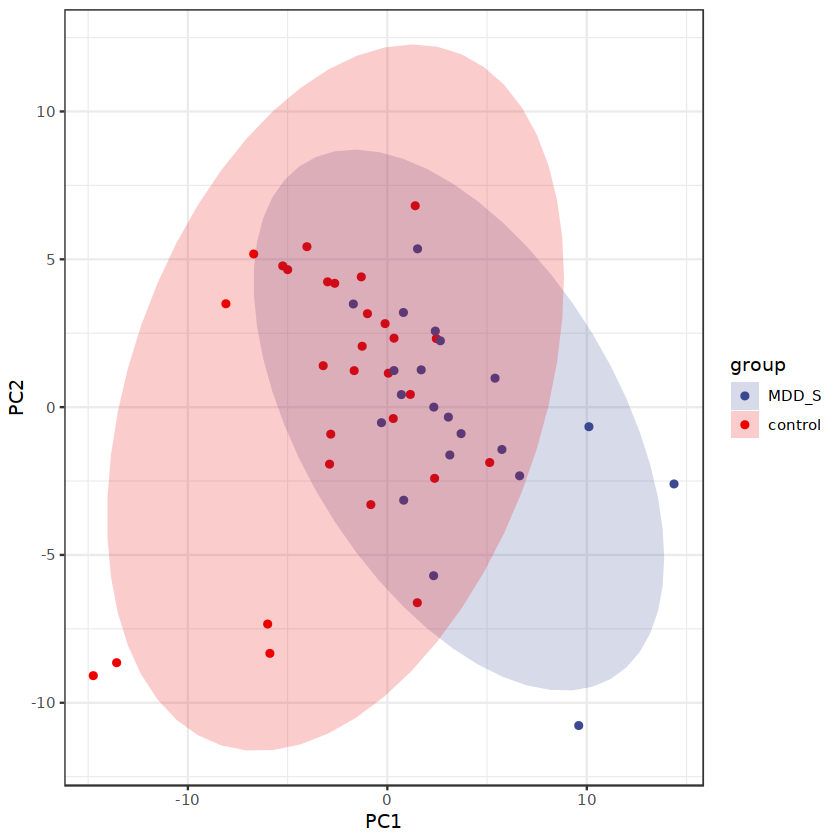

In [138]:
ggplot(tmp, aes(PC1, PC2))+
  geom_point(aes(color = group))+
  stat_ellipse(aes(fill=group), alpha = 0.2,
               geom ="polygon",type = "norm")+
  scale_fill_aaas()+
  scale_color_aaas()+
  theme_bw()

In [139]:
ge = readRDS('./diff.rds')

In [140]:
up1 =ge %>% dplyr::filter(change == 'Up') %>%  rownames()

In [141]:
up2 = diff %>%  dplyr::filter(group == 'Up') %>%  rownames()

In [142]:
intersect(up1,up2)

character(0)

In [143]:
up1 =ge %>% dplyr::filter(change == 'Down') %>%  rownames()

In [144]:
up2 = diff %>%  dplyr::filter(group == 'Down') %>%  rownames()

In [145]:
intersect(up1,up2)

[1] "ADAMTS1" "S1PR1"

### 模型构建

In [ ]:
cg1 = cg[!grepl('^LINC',cg)]

cg2 = cg1[!grepl('^LOC',cg1)]

cg2

exp1 = exp[cg2,] %>%  t() 

save(exp1,group,file = 'bulk2.rda')

In [36]:
crg = read.table('./00_rawdata/crg.txt',header =T,sep = '\t')

In [37]:
head(crg,1)

,MGI.Gene.Marker.ID,Symbol,Name,Chr,Qualifier,Annotated.Term,Context,Proteoform,Evidence,Inferred.From,Reference.s.
,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,MGI:1919440,2510009E07Rik,RIKEN cDNA 2510009E07 gene,16,NA,circadian behavior,,,ISS,Q1LY84,J:342587


In [38]:
library(homologene)

In [39]:
genelist = crg$Symbol
homo = homologene(genelist, inTax = 10090, outTax = 9606)

In [40]:
head(homo,2)

,10090,9606,10090_ID,9606_ID
,<chr>,<chr>,<int>,<int>
1,2510009E07Rik,C3orf70,72190,285382
2,Aanat,AANAT,11298,15


In [41]:
table(diff$group)


     Down NoSignifi        Up 
      942     29533      1031 

In [42]:
head(diff,2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
MRPS6,-0.06437148,5.816362,-4.594553,2.275043e-05,0.3737141,2.260433,Down
LINC00943,-0.32588974,5.262539,-4.140891,1.097314e-04,0.6621735,1.144005,Down


In [43]:
diff$change = diff$group

In [44]:
library(dplyr)

In [45]:
data <- 
  diff %>% 
  mutate(change = as.factor(ifelse(P.Value < 0.05 & abs(logFC) > 0,
                                   ifelse(logFC > 0 ,'Up','Down'),'NOT'))) %>% 
  tibble::rownames_to_column('gene')

In [46]:
table(data$change)


 Down   NOT    Up 
  942 29533  1031 

In [47]:
head(data,3)

,gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,group,change
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,MRPS6,-0.06437148,5.816362,-4.594553,2.275043e-05,0.3737141,2.2604331,Down,Down
2,LINC00943,-0.32588974,5.262539,-4.140891,1.097314e-04,0.6621735,1.1440054,Down,Down
3,TUBD1,0.06094105,5.596678,3.947998,2.093795e-04,0.6621735,0.3678197,Up,Up


In [48]:
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(cowplot)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'ggpubr' was built under R version 4.2.3"
Warning message:
"package 'ggrepel' was built under R version 4.2.3"
Warning message:
"package 'cowplot' was built under R version 4.2.3"

Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend




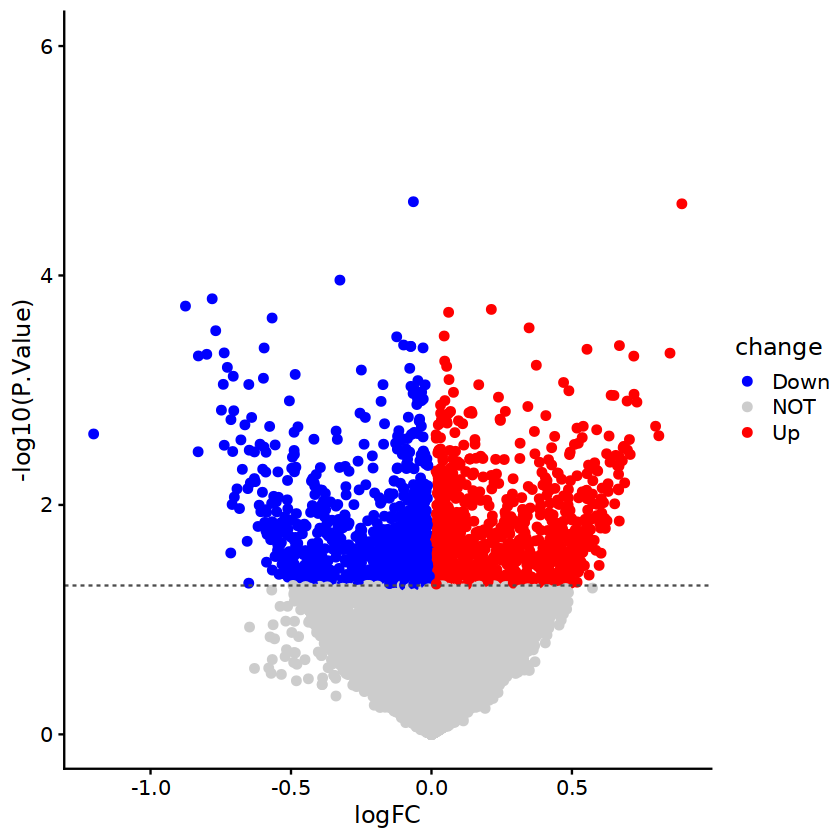

In [49]:
top_5 <- bind_rows(   
      data %>%
        filter(change == 'Up') %>%
        arrange(P.Value, desc(logFC)) %>%
        head(0),
      data %>%
        filter(change == 'Down') %>%
        arrange(P.Value, desc(logFC)) %>%
        head(0)
    )
    ggplot(data=data,aes(x=logFC,y=-log10(P.Value)))+
    geom_point(aes(color=change),size=2)+
    geom_hline(yintercept = -log10(0.05), linetype="dashed",color="grey30")+
    #geom_vline(xintercept = c(-0.3,0.3),linetype="dashed",color="grey30")+
    geom_text_repel(data=top_5,aes(x= logFC,y= -log10(P.Value),label= rownames(top_5)))+
    scale_color_manual(values = c("blue","grey80","red"))+
    theme_half_open() +ylim(0,6)#+xlim(-1.5,1.5)
    ggsave('Volcano.pdf',height = 8,width = 8)

In [50]:
diff1 = data %>%  dplyr::filter(change != 'NOT')

In [51]:
dim(diff1)

[1] 1973    9

In [52]:
tail(diff1,2)

,gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,group,change
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1972,GLUL,-0.03391529,6.713593,-2.074812,0.04229643,0.7814547,-5.975514,Down,Down
1973,MTURN,0.01713250,6.691455,2.009638,0.04896861,0.7939472,-6.062679,Up,Up


In [53]:
sample_list <- list(DEGs = diff1$gene, CRGs = homo[,2])

In [54]:
library(venn)
        library(VennDiagram)
        color=c( "#3C5488B2","#00A087B2", 
             "#F39B7FB2","#91D1C2B2", 
             "#8491B4B2", "#DC0000B2", 
             "#7E6148B2","yellow", 
             "darkolivegreen1", "lightskyblue", 
             "darkgreen", "deeppink", "khaki2", 
             "firebrick", "brown1", "darkorange1", 
             "cyan1", "royalblue4", "darksalmon", 
             "darkgoldenrod1", "darkseagreen", "darkorchid")

Warning message:
"package 'venn' was built under R version 4.2.3"
Loading required package: grid

Loading required package: futile.logger

Warning message:
"package 'futile.logger' was built under R version 4.2.3"

Attaching package: 'VennDiagram'


The following object is masked from 'package:ggpubr':

    rotate




In [55]:
q <- venn.diagram(sample_list,filename = NULL,
             fill = color[1:(length(sample_list))],
             alpha = 0.50, cat.col = rep('black', 2), 
             col = 'black', cex = 1, fontfamily = 'serif', cat.cex = 1, cat.fontfamily = 'serif', margin = 0.2
                             )
    pdf(paste0('./',"venn.pdf"))
    grid.draw(q)
    dev.off()

png 
  2

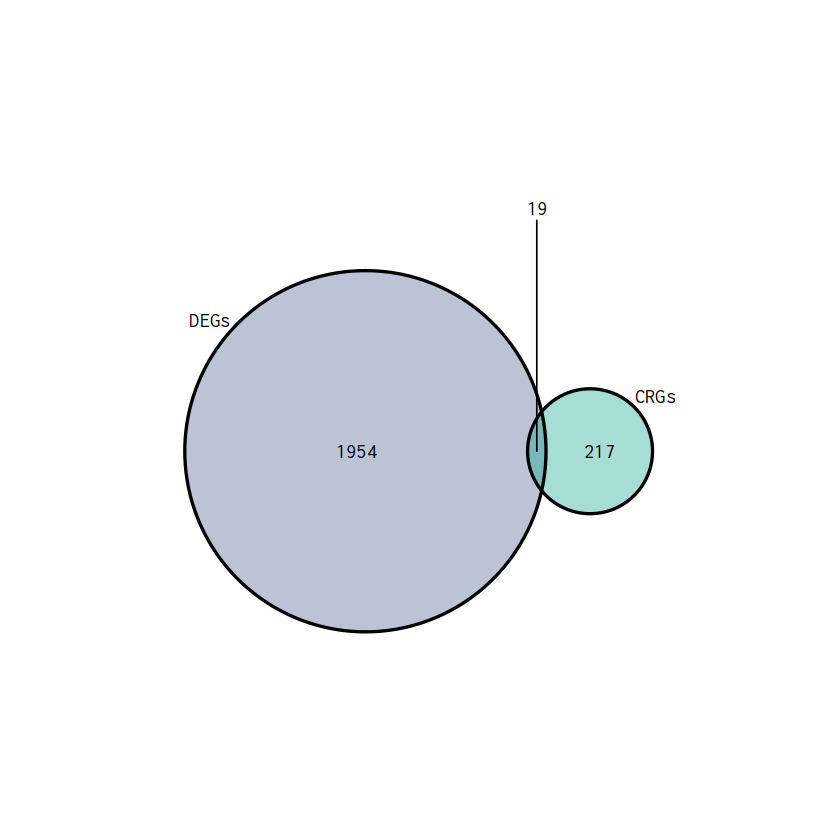

In [56]:
grid.draw(q)

In [57]:
jiaoji = intersect(diff1$gene,homo[,2])

In [242]:
#exp<- read.table("./00_rawdata/exp.txt",sep = '\t',header = T,row.names = 1) 

In [58]:
data1 = exp[jiaoji,]

In [59]:
dim(data1)

[1] 19 59

In [60]:
head(data1,2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V11,...,V28,V31,V38,V41,V48,V50,V51,V54,V55,V56
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPE65,3.694608,3.612550,3.050758,4.653209,4.078557,4.338465,3.012600,4.294020,3.955365,4.295561,...,1.654528,3.6644160,2.96051,3.54595,3.690635,3.521042,1.2192795,3.195317,2.279349,2.529250
DRD3,0.000000,1.168619,1.146924,1.825147,1.959796,1.767155,1.362414,1.471464,2.210432,0.000000,...,0.000000,0.7907414,0.00000,0.00000,0.000000,1.457676,0.7347872,0.000000,1.192108,1.480145


In [61]:
gene <- t(data1)

In [62]:
#gene <- log(gene+1)

In [63]:
gene_cor <- cor(gene, method = 'pearson')

In [64]:
diag(gene_cor) <- 0

In [65]:
gene_cor <- reshape2::melt(gene_cor)
gene_cor <- subset(gene_cor, value != 0)  #去除0值的相关性
head(gene_cor)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
2,DRD3,RPE65,0.371205985
3,MC3R,RPE65,0.224696020
4,GPR157,RPE65,-0.149923481
5,RELB,RPE65,0.316433987
6,NFIL3,RPE65,0.183009841
7,NMS,RPE65,-0.006270724


In [66]:
library(circlize)
pdf('cor.circle.pdf',height = 6,width = 6)
p=chordDiagram(gene_cor, 
    annotationTrack = c('grid', 'name', 'axis'), #绘制外周圆弧区，显示名称和刻度轴
    grid.col = c(GABRD = 'green3', PLVAP = 'red', CDKN3 = 'orange', CDC25C = 'purple', UBE2T = 'skyblue', SKA1 = 'blue'), #定义基因颜色
    col = colorRamp2(c(-1, 0, 1), c('green', 'white', 'red'), transparency = 0.5), #根据相关性大小展示连线的颜色范围
    annotationTrackHeight = c(0.05, 0.05), #名称离圆弧的距离，以及圆弧的宽度
)
dev.off()

circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




png 
  2

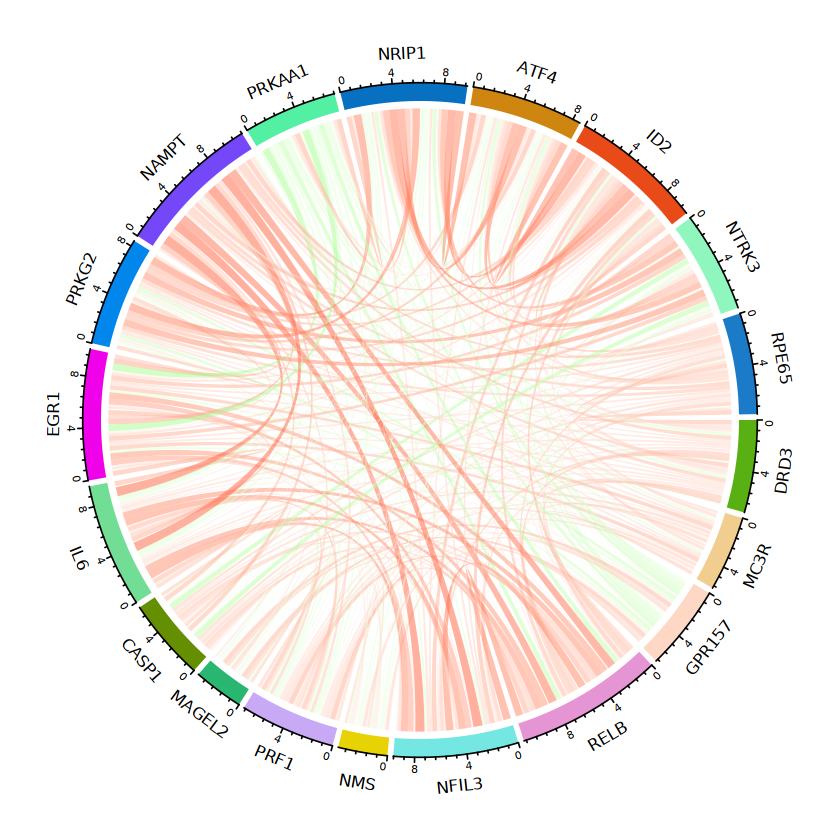

In [67]:
chordDiagram(gene_cor, 
    annotationTrack = c('grid', 'name', 'axis'), #绘制外周圆弧区，显示名称和刻度轴
    #grid.col = c(GABRD = 'green3', PLVAP = 'red', CDKN3 = 'orange', CDC25C = 'purple', UBE2T = 'skyblue', SKA1 = 'blue'), #定义基因颜色
    col = colorRamp2(c(-1, 0, 1), c('green', 'white', 'red'), transparency = 0.5), #根据相关性大小展示连线的颜色范围
    annotationTrackHeight = c(0.05, 0.05), )#名称离圆弧的距离，以及圆弧的宽度

In [68]:
head(data1,2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V11,...,V28,V31,V38,V41,V48,V50,V51,V54,V55,V56
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPE65,3.694608,3.612550,3.050758,4.653209,4.078557,4.338465,3.012600,4.294020,3.955365,4.295561,...,1.654528,3.6644160,2.96051,3.54595,3.690635,3.521042,1.2192795,3.195317,2.279349,2.529250
DRD3,0.000000,1.168619,1.146924,1.825147,1.959796,1.767155,1.362414,1.471464,2.210432,0.000000,...,0.000000,0.7907414,0.00000,0.00000,0.000000,1.457676,0.7347872,0.000000,1.192108,1.480145


In [69]:
library(pheatmap)

Warning message:
"package 'pheatmap' was built under R version 4.2.3"


In [73]:
da = data1

In [74]:
#da=log2(data1+1)
dat=t(scale(t(da))) # 'scale'可以对log(fpkm+1)数值进行归一化
#处理数据
dat[dat>2]=2
dat[dat<(-2)]= -2
dim(dat)

[1] 19 59

In [75]:
options(repr.plot.width = 8,repr.plot.height = 4)

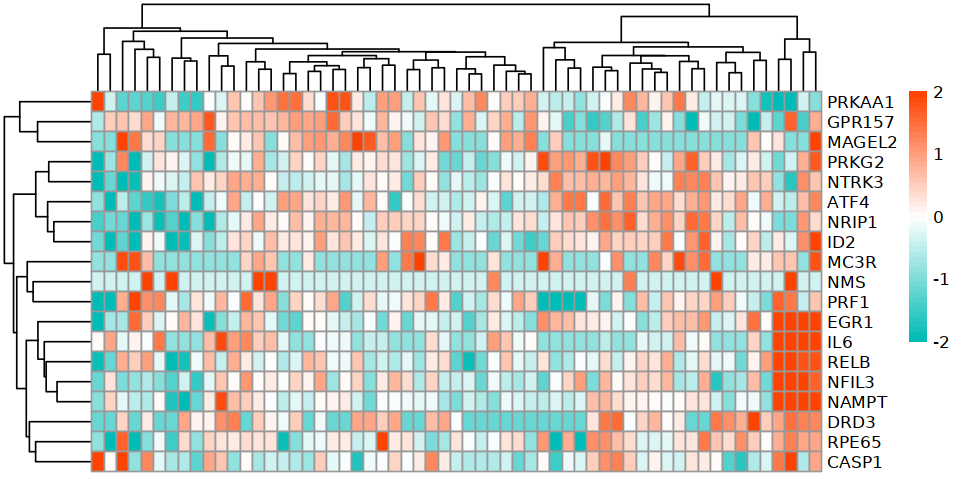

In [76]:
xx = pheatmap(dat,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         show_rownames=TRUE,
         show_colnames = FALSE,
          scale="none",
          #cluster_cols = F,
          fontsize_row = 10,
          fontsize_col = 10,
          #color = colorRampPalette(c("navy", "white", "firebrick3"))(100),
          color = colorRampPalette(c("#00BCB6", "white", "#FE4300"))(50),#换颜色
          angle_col = 45 #修改横轴坐标名倾斜度
)

In [77]:
save_pheatmap_pdf <- function(x, filename, width=8, height=6) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

save_pheatmap_pdf(xx, "heatmap.pdf")

png 
  2

In [78]:
library(readxl)

Warning message:
"package 'readxl' was built under R version 4.2.3"


In [79]:
group = cli[,c(1,2)]

In [80]:
colnames(group) = c('Symbol','Group')

In [81]:
head(group,2)

,Symbol,Group
,<chr>,<chr>
V35,V35,MDD
V36,V36,MDD


In [82]:
expr = gene %>% as.data.frame() %>% 
tibble::rownames_to_column(.,'sample')

In [83]:
expr1 = merge(group,expr,by.x = 'Symbol',by.y = 'sample')

In [84]:
head(expr1,2)

,Symbol,Group,RPE65,DRD3,MC3R,GPR157,RELB,NFIL3,NMS,PRF1,...,CASP1,IL6,EGR1,PRKG2,NAMPT,PRKAA1,NRIP1,ATF4,ID2,NTRK3
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,V1,CON,3.694608,0,1.31814,0.000000,4.548540,6.428383,0,2.801941,...,4.54854,1.318140,8.876338,8.153575,9.757731,9.263987,10.785255,10.194585,10.033292,12.36519
2,V10,MDD,2.381054,0,0.00000,2.381054,3.526436,6.003098,0,0.000000,...,6.67271,1.634401,4.929043,6.049678,9.215517,9.637592,9.849888,9.614537,9.337863,10.11376


In [85]:
require(cowplot)
require(tidyverse)
require(ggplot2)
require(ggsci)
require(ggpubr)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.2.1     v purrr   1.0.1
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.4     v forcats 1.0.0
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x ggplot2::Position()  masks BiocGenerics::Position(), base::Position()
x IRanges::collapse()  masks dplyr::collapse()
x Biobase::combine()   masks BiocGenerics::combine(), dplyr::comb

In [86]:
mydata<-expr1 %>% 
  ## 基因表达数据gather,gather的范围应调整
  gather(key="gene",value="Expression",RPE65:NTRK3) %>% 
  ##
  dplyr::select(Group,gene,Expression) 

In [87]:
head(mydata,2)

,Group,gene,Expression
,<chr>,<chr>,<dbl>
1,CON,RPE65,3.694608
2,MDD,RPE65,2.381054


In [88]:
compare_means( Expression ~ Group, data = mydata, method = 't.test',
              group.by = "gene")
# Box plot facetted by "gene"
p <- ggboxplot(mydata, x = "Group", y = "Expression",
          color = "Group", palette = "jco",
          add = "jitter",
          facet.by = "gene", short.panel.labs = FALSE)
# Use only p.format as label. Remove method name.
#p + stat_compare_means(label =  "p.signif", label.x = 1.5)
p <- ggboxplot(mydata, x = "gene", y = "Expression",
          color = "Group", palette = "nejm",
          add = "jitter")

gene,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
RPE65,Expression,CON,MDD,0.0001385722,0.0026,0.00014,***,T-test
DRD3,Expression,CON,MDD,0.0027391718,0.0490,0.00274,**,T-test
MC3R,Expression,CON,MDD,0.0044667703,0.0760,0.00447,**,T-test
GPR157,Expression,CON,MDD,0.0314425418,0.3500,0.03144,*,T-test
RELB,Expression,CON,MDD,0.0166906343,0.2400,0.01669,*,T-test
NFIL3,Expression,CON,MDD,0.0107627625,0.1700,0.01076,*,T-test
NMS,Expression,CON,MDD,0.0483725055,0.3500,0.04837,*,T-test
PRF1,Expression,CON,MDD,0.0323607987,0.3500,0.03236,*,T-test
MAGEL2,Expression,CON,MDD,0.0843938264,0.3500,0.08439,ns,T-test


In [ ]:
diffgene = as.data.frame(compare_means( Expression ~ Group, data = mydata, method = 't.test',
              group.by = "gene"))
diffgene = rownames(diffgene) = diffgene[,1]
write.csv(diffgene,file = 'diffgene.csv')
options(repr.plot.height = 5,repr.plot.width = 9)

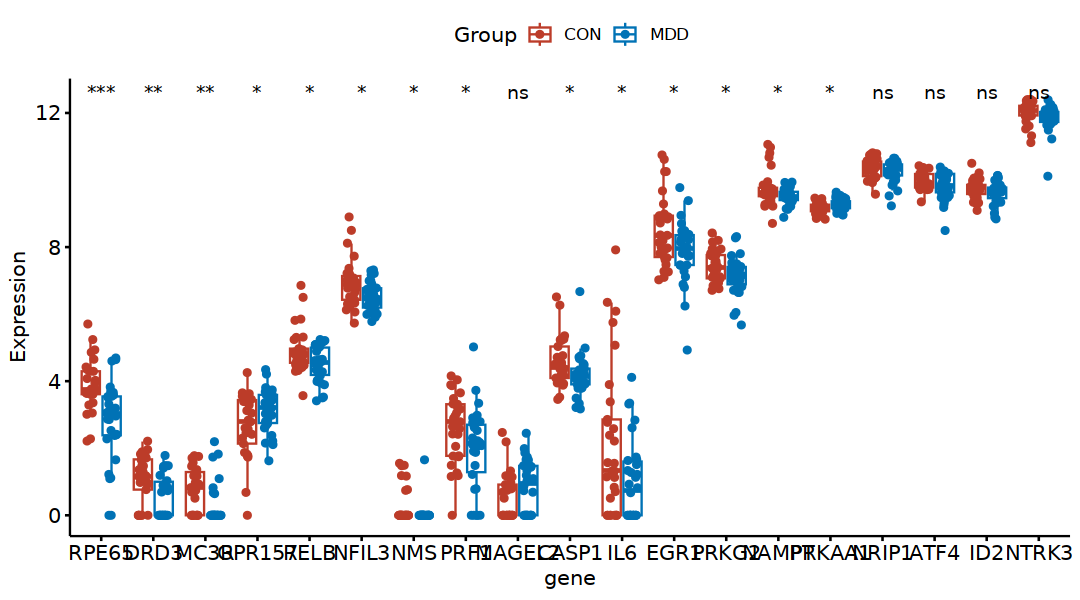

In [93]:
p + stat_compare_means(aes(group = Group), label = "p.signif",method = 't.test')

In [94]:
ggsave('boxplot.pdf',height = 6,width = 16)

In [95]:
library(clusterProfiler)
library(org.Hs.eg.db)



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProf

In [98]:
 gene_symbol <- bitr(geneID = jiaoji,  
                        fromType="SYMBOL",   
                        toType=c("ENTREZID"),  
                        OrgDb="org.Hs.eg.db")
    gene <- gene_symbol[,2]
    BP <- enrichGO(gene = gene,  
                   keyType = "ENTREZID",  
                   OrgDb=org.Hs.eg.db,  
                   ont = "ALL",   
                   pvalueCutoff = 0.05,  
                   pAdjustMethod = "fdr", 
                   minGSSize = 5,   
                   maxGSSize = 500,  
                   qvalueCutoff = 1,  
                   readable = TRUE) 

'select()' returned 1:1 mapping between keys and columns



In [99]:
head(BP,2)

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0007623,BP,GO:0007623,circadian rhythm,14/19,210/18903,3.117035e-24,4.204881e-21,2.234422e-21,RPE65/DRD3/MC3R/GPR157/RELB/NFIL3/NMS/MAGEL2/EGR1/NAMPT/PRKAA1/NRIP1/ATF4/ID2,14
GO:0048511,BP,GO:0048511,rhythmic process,14/19,302/18903,5.653049e-22,3.812981e-19,2.026172e-19,RPE65/DRD3/MC3R/GPR157/RELB/NFIL3/NMS/MAGEL2/EGR1/NAMPT/PRKAA1/NRIP1/ATF4/ID2,14


In [101]:
 BP %>% filter(ONTOLOGY	 == 'BP') %>% head(5) -> bp
 BP %>% filter(ONTOLOGY	 == 'MF') %>% head(5) -> mf
 BP %>% filter(ONTOLOGY	 == 'CC') %>% head(5) -> cc

In [109]:
go = rbind(bp,cc,mf)

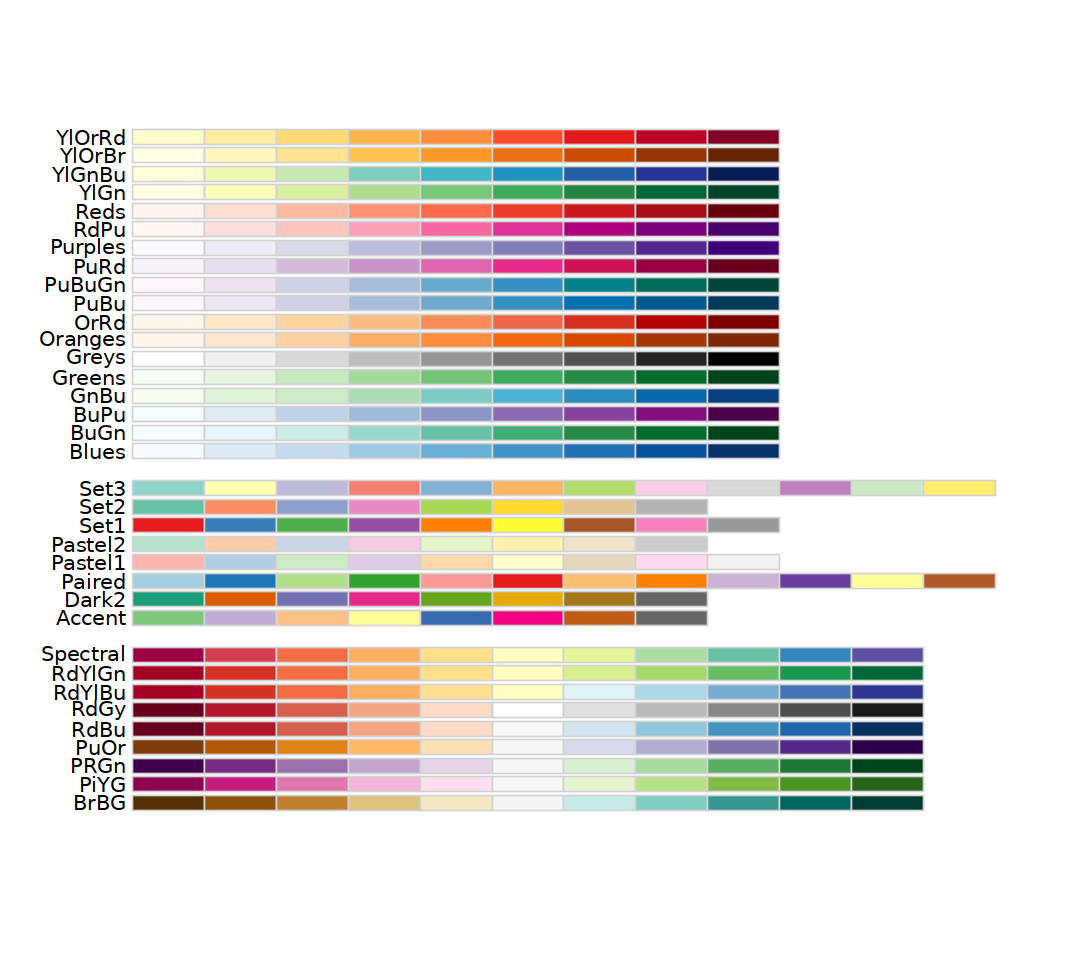

In [110]:
library(ggplot2)
library(RColorBrewer)
display.brewer.all()
color <- brewer.pal(3,"Dark2")
colorl <- rep(color,each=5)

In [114]:
options(repr.plot.height = 5)

In [115]:
go$Description<- factor(go$Description,levels=go$Description)

Warning message:
"Vectorized input to `element_text()` is not officially supported.
i Results may be unexpected or may change in future versions of ggplot2."


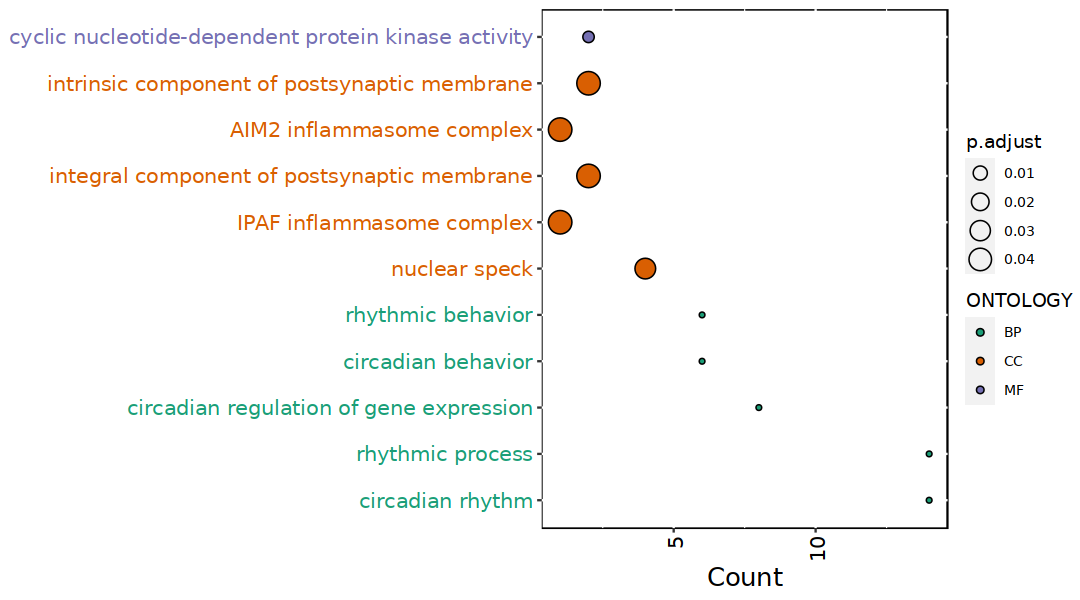

In [116]:
ggplot(go) +
  aes(x = Description, y = Count, fill = ONTOLOGY,size=p.adjust) +
  geom_point(shape=21,color="black") +
  #scale_fill_hue() +
  xlab("Counts")+
  scale_fill_manual(values =color)+
  coord_flip()+
  theme(
    axis.title=element_text(size=15,face="plain",color="black"),
    axis.text = element_text(size=12,face="plain",color="black"),
    axis.text.x = element_text(angle = 90,hjust=1,vjust=0.6),
    axis.title.y = element_blank(),
    axis.text.y = element_text(colour = colorl),
    #legend.title = element_blank(),
    legend.text = element_text(size = 8, face = "bold"),
    legend.margin = margin(t = 0, r = 0, b = 0, l = 0, unit = "pt"),
    #legend.direction = "horizontal",
    #legend.position = c(0.5,0.9),
    legend.background = element_blank(),
    panel.background = element_rect(fill = "transparent",colour = "black"),
    plot.background = element_blank()
  )

In [117]:
pdf('go.pdf',height = 8,width = 6)

In [118]:
library(enrichplot)

Warning message:
"package 'enrichplot' was built under R version 4.2.2"

Attaching package: 'enrichplot'


The following object is masked from 'package:ggpubr':

    color_palette




Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(category_label = your_value)' instead of 'cex_label_category'.
 The cex_label_category parameter will be removed in the next version."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(line = your_value)' instead of 'cex_line'.
 The cex_line parameter will be removed in the next version."
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


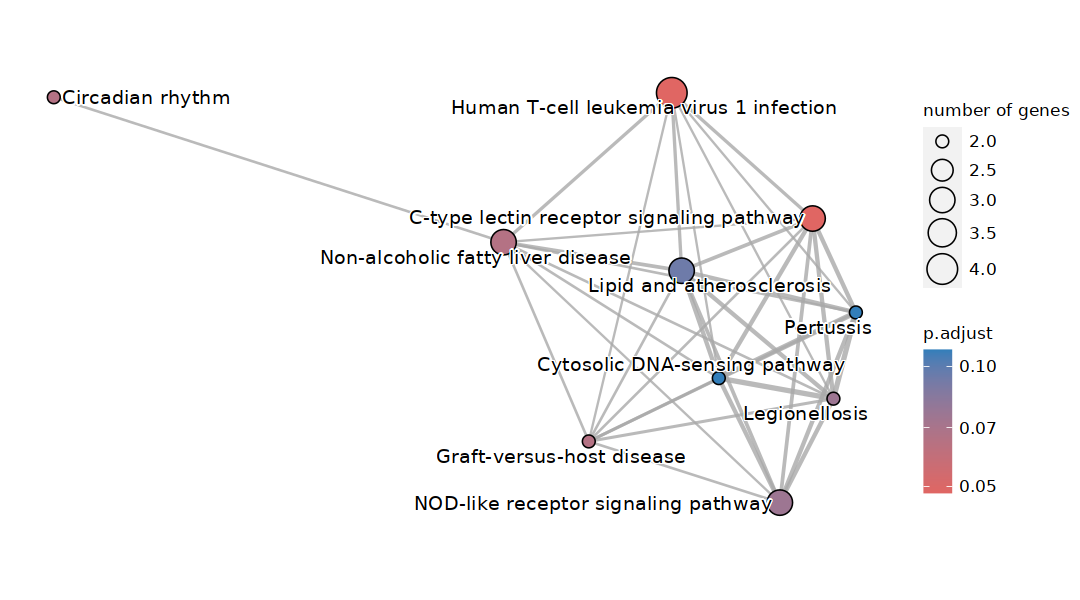

In [120]:
 ek <- enrichKEGG(gene =gene , 
                   organism = "hsa",  
                   pvalueCutoff =1, 
                   qvalueCutoff = 1) 
    keggres = ek@result
    write.csv(keggres,file = 'kegg_results.csv')
    KEGG2 <- pairwise_termsim(ek)
    emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 10) + 
      ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                            guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
    ggsave('KEGG_enrichment_net.pdf',height = 8,width = 8) 

In [121]:
rownames(expr1) = expr1[,1]

In [122]:
saveRDS(expr1,file = 'expr.rds')